#PyTorch Intro - Trenowanie i Ewaluacja Sieci Neuronowej - Lab


#Zadanie

Zaadaptuj kod z notatnika *PyTorch Intro - Trenowanie i Ewaluacja Sieci Neuronowej - Wykład* do problemu klasyfikacji liczby gwiazdek dla opinii z serwisu Yelp.
Możesz przygotować pętlę treningową albo w czystym PyTorchu, albo z wykorzystaniem biblioteki PyTorch Lightning.

* Wykorzystaj zbiór `Yelp/yelp_review_full` ([link](https://huggingface.co/datasets/Yelp/yelp_review_full)) zawierający opinie z serwisu Yelp (kolumna: `text`) i etykietę (kolumna: `label`) o wartościach $0,1,2,3,4$ określającą liczbę gwiazdek przyznaną przez użytkownika (a ściślej, liczbę gwiazdek minus jeden). Ponieważ mamy pięć klas, ostatnia warstwa liniowa w sieci neuronowej musi zwracać pięć wartości.
    * Zgodnie z dobrą praktyką z części treningowej wydziel dodatkową część walidacyjną.
    * Ogranicz rozmiar każdej części zbioru danych (treningowej, walidacyjnej i testowej). Część treningowa nie powinna zawierać więcej niż 100k elementów.
* Do ekstrakcji cech z tekstu wykorzystaj **metodę TF-IDF** (*term frequency-inverse document frequency*) opartą o podejście typu worek słów (*bag-of-words*). Zastosuj funkcję `TfidfVectorizer` z biblioteki `scikit-learn`.
* Wykorzystaj podobną architekturę sieci (perceptron wielowarstwowy z warstwą Dropout) jak w notatniku wykładowym.



## Punkty do wykonania

1.   
Napisz funkcję znajdującą i wyświetlającą $k$ elementów zbioru testowego dla których model najbardziej się myli, czyli estymuje najmniejsze prawdopodobieństwa prawdziwej klasy. Softmax jest funkcją ściśle rosnącą, więc wystarczy znaleźć elementy z najmniejszą wartością nieznormalizowanego wyjścia z sieci (logita) dla prawdziwej klasy.
2.   Zbadaj wpływ wybranych parametrów funkcji ekstrakcji cech z tekstu `TfidfVectorizer` na skuteczność wytrenowanego modelu. Uruchom kilka eksperymentów z różnymi wartościami parametrów i porównaj dokładność wytrenowanego modelu na zbiorze walidacyjnym.
3.   Zbadaj wpływ wybranych hiperparametrów modelu (np. liczba warstw liniowych modelu, rozmiary warstw) i procesu uczenia (np. początkowa wartość stopy uczenia, liczba epok, typ i parametry planisty stopy uczenia, typ i parametry optymalizatora) na skuteczność wytrenowanego modelu. Uruchom kilka eksperymentów z różnymi wartościami hiperparametrów i porównaj dokładność wytrenowanego modelu na zbiorze walidacyjnym. Następnie wykonaj finalną ewaluację najlepszego modelu na zbiorze testowym.


##Przygotowanie środowiska
Upewnij się, że notatnik jest uruchomiony na maszynie z GPU. Jesli GPU nie jest dostępne zmień typ maszyny (Runtime | Change runtime type) i wybierz T4 GPU.

In [1]:
!nvidia-smi

Wed Apr  9 22:06:21 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   41C    P8              9W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

Instalacja dodatkowych bibliotek: datasets (z biblioteki HuggingFace), TorchMetrics i W&B (Weights and Biases) Models.

In [2]:
!pip install -q datasets
!pip install -q torchmetrics
!pip install -q wandb



Import bibliotek.

In [3]:
import torch
import numpy as np
import matplotlib.pyplot as plt

print(f"Wersja biblioteki PyTorch: {torch.__version__}")

Wersja biblioteki PyTorch: 2.6.0+cu124


Sprawdzenie dostępności GPU.

In [4]:
print(f"Dostępność GPU: {torch.cuda.is_available()}")
print(f"Typ GPU: {torch.cuda.get_device_name(0)}")

Dostępność GPU: True
Typ GPU: Tesla T4


In [5]:
import wandb

# Logowanie do serwisu Weights&Biases monitorującego przebieg eksperymentów
wandb.login()

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: jonczykalicja03 (jonczykalicja03-politechnika-warszawska) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

# Rozwiązanie

Pobranie danych oraz ograniczenie wielkości zbiorów

In [6]:
from datasets import load_dataset

# Load the dataset
dataset = load_dataset("Yelp/yelp_review_full")
print(dataset)

test_dataset = dataset["test"]

# Wydziel część walidacyjną ze zbioru treningowego
split_dataset = dataset["train"].train_test_split(test_size=0.2)  # 80% train, 20% validation
train_dataset = split_dataset["train"]
val_dataset = split_dataset["test"]

# Utwórz mniejsze podzbiory treningowe, walidacyjne i testowe
train_dataset = train_dataset.shuffle().select(range(int(len(train_dataset) * .15)))
val_dataset = val_dataset.shuffle().select(range(int(len(val_dataset) * .1)))
test_dataset = test_dataset.shuffle().select(range(int(len(test_dataset) * .4)))

print(f"Liczba próbek w zbiorze treningowym: {len(train_dataset)}")
print(f"Liczba próbek w zbiorze walidacyjnym: {len(val_dataset)}")
print(f"Liczba próbek w zbiorze testowym: {len(test_dataset)}")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


DatasetDict({
    train: Dataset({
        features: ['label', 'text'],
        num_rows: 650000
    })
    test: Dataset({
        features: ['label', 'text'],
        num_rows: 50000
    })
})
Liczba próbek w zbiorze treningowym: 78000
Liczba próbek w zbiorze walidacyjnym: 13000
Liczba próbek w zbiorze testowym: 20000


Sprawdzenie liczby elementów z każdej klasy w zbiorze treningowym.


Przykładowy element ze zbioru danych:
sample['text']='My husband and I went into have my favored BBQ chicken salad , and a burger for him , I was so sad it was so bad food and service had to ask for everything and wait longer for her to bring it to us . On the plus side the seaters are on the ball great job girls , she got our drinks and frys for us.'
sample['label']=1


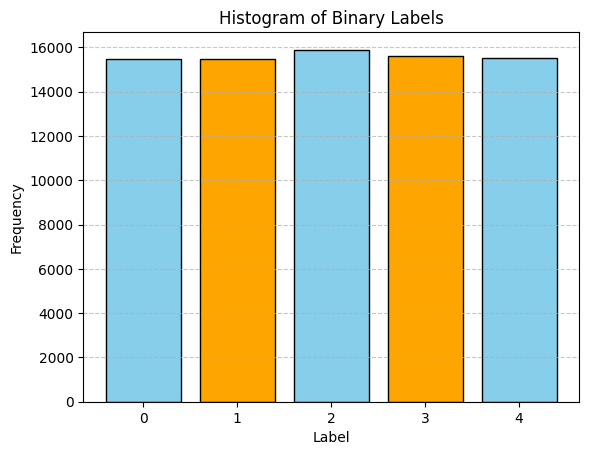

In [7]:
sample = train_dataset[123]
print(f"\nPrzykładowy element ze zbioru danych:")
print(f"{sample['text']=}")
print(f"{sample['label']=}")

# Count occurrences of each label
unique_labels, counts = np.unique(train_dataset['label'], return_counts=True)

# Plot histogram
plt.bar(unique_labels, counts, color=['skyblue', 'orange'], edgecolor='black')
plt.title('Histogram of Binary Labels')
plt.xlabel('Label')
plt.ylabel('Frequency')
plt.xticks(unique_labels)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

Ekstrakcja cech

In [8]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn import metrics

from tqdm import tqdm

Rozmiar macierzy TF-IDF dla zbioru treningowego: (78000, 10000)
train_tfidf_features.dtype=dtype('float64')

Liczba cech: 10000
Przykładowe cechy: ['block' 'regulars' 'disorganized' 'expanding' 'nthese' 'slightest'
 'yelling' 'reds' 'lisa' 'shipping' 'crisis' 'apprehensive' 'sarcastic'
 'celebrities' 'collect' 'enclosed' 'followed' 'care' 'nlast' 'weeks']

Element zbioru treningowego o indeksie=111
train_dataset['text'][ndx]="Don't like at all... Too doughy and too expensive. Not very good pizza. It reminds me if Papa John's (gross)."

Cechy elementu o indeksie=111:
Kolumna: 2725 (don)   Waga: 0.15783
Kolumna: 2751 (doughy)   Waga: 0.43999
Kolumna: 3162 (expensive)   Waga: 0.25971
Kolumna: 3798 (good)   Waga: 0.11550
Kolumna: 3903 (gross)   Waga: 0.32021
Kolumna: 4638 (john)   Waga: 0.40297
Kolumna: 4972 (like)   Waga: 0.12641
Kolumna: 6418 (papa)   Waga: 0.46739
Kolumna: 6695 (pizza)   Waga: 0.23806
Kolumna: 7350 (reminds)   Waga: 0.38038
Średnia liczba niezerowych cech w próbkach: 47

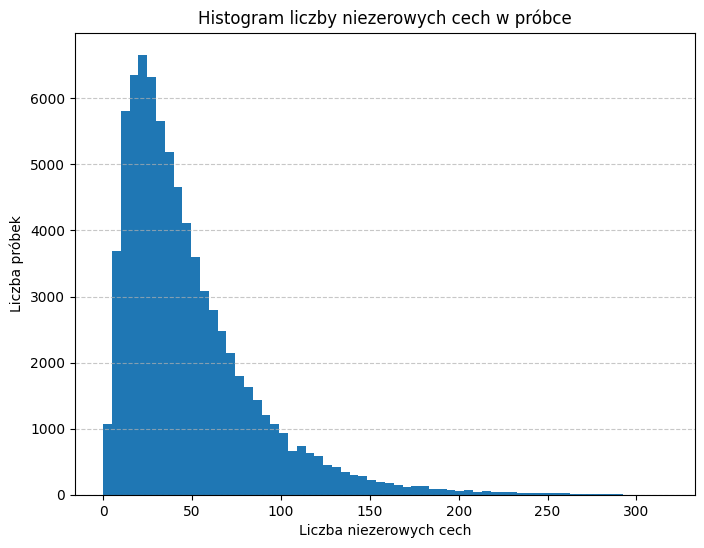

In [9]:
from sklearn.feature_extraction.text import TfidfVectorizer

vocab_size = 10000

vectorizer = TfidfVectorizer(
    max_features=vocab_size,    # Ogranicz do max_features najczęściej występujących słów
    lowercase=True,             # Przekształć na małe litery
    analyzer='word',            # Analiza na poziomie słów (a nie pojedynczych znaków)
    ngram_range=(1, 1),         # Unigramy (pojedynczne słowa)
    stop_words="english"        # Usuń częste słowa w języku angielskim (np. a, the, and)
)

# Ekstrakcja cech
# Na zbiorze treningowym stosujemy funkcję fit_transform() która wyznacza cech i dokonuje ich ekstrakcji
train_tfidf_features = vectorizer.fit_transform(train_dataset["text"])
# Na zbiorze walidacyjnym i testowym stosujemy funkcję transform() które dokonuje ekstrakcji tych samych cech co na zbiorze treningowym
val_tfidf_features = vectorizer.transform(val_dataset["text"])
test_tfidf_features = vectorizer.transform(test_dataset["text"])

print(f"Rozmiar macierzy TF-IDF dla zbioru treningowego: {train_tfidf_features.shape}")
print(f"{train_tfidf_features.dtype=}\n")

feature_names = vectorizer.get_feature_names_out()
print(f"Liczba cech: {len(feature_names)}")
print(f"Przykładowe cechy: {np.random.choice(feature_names, 20)}\n")

ndx = 111
print(f"Element zbioru treningowego o indeksie={ndx}")
print(f"{train_dataset['text'][ndx]=}\n")
features = train_tfidf_features[ndx]
print(f"Cechy elementu o indeksie={ndx}:")
non_zero_cols = features.nonzero()[1]

non_zero_cols = sorted(non_zero_cols)
for i in non_zero_cols:
    print(f"Kolumna: {i} ({feature_names[i]})   Waga: {features[0, i]:.5f}")


non_zero_counts = np.diff(train_tfidf_features.indptr)
print(f"Średnia liczba niezerowych cech w próbkach: {non_zero_counts.mean():.2f}")

# Plot histogram
plt.figure(figsize=(8, 6))
plt.hist(non_zero_counts, bins=64)
plt.title('Histogram liczby niezerowych cech w próbce')
plt.xlabel('Liczba niezerowych cech')
plt.ylabel('Liczba próbek')
plt.grid(axis='y', linestyle='--', alpha=0.7)

Przygotowanie zbioru danych w PyTorch

In [10]:
import torch

from torch.utils.data import TensorDataset, DataLoader

In [11]:
def make_dataset(sparse_features, labels):
    # Zamień rzadką macierz cech na zwykłą (gęstą) macierz ndarray
    dense_features = sparse_features.astype(np.float32).todense()
    # Utwórz zbiór danych na podstawie tensora z cechami i tensora z etykietami
    dataset = TensorDataset(
        torch.from_numpy(dense_features),
        torch.tensor(labels, dtype=torch.int64)
    )
    return dataset

# Utwórz trzy zbiory danych: treningowy, walidacyjny i testowy
datasets = {
    'train': make_dataset(train_tfidf_features, train_dataset['label']),
    'val': make_dataset(val_tfidf_features, val_dataset['label']),
    'test': make_dataset(test_tfidf_features, test_dataset['label'])
}

# Wyświetl przykładowy element
print(datasets['train'][0])

(tensor([0., 0., 0.,  ..., 0., 0., 0.]), tensor(3))


In [12]:
batch_size = 256

dataloaders = {split: DataLoader(datasets[split], batch_size=batch_size, shuffle=split=='train', num_workers=0) for split in datasets}

for X_batch, y_batch in dataloaders['train']:
    print(f"{X_batch.shape=}")
    print(f"{y_batch.shape=}")
    break

X_batch.shape=torch.Size([256, 10000])
y_batch.shape=torch.Size([256])


Utworzenie modelu sieci neuronowej

In [13]:
import torch.nn as nn


class SimpleNet(nn.Module):
    def __init__(self, vocab_size: int, n_classes: int):
        super().__init__()
        self.vocab_size = vocab_size
        self.n_classes = n_classes

        self.feature_extractor = nn.Sequential(
            nn.Linear(self.vocab_size, 64),
            nn.ReLU(),
            nn.Linear(64, 16),
            nn.ReLU()
        )
        self.dropout = nn.Dropout(0.1)
        self.linear = nn.Linear(16, n_classes)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        features = self.feature_extractor(x)
        features = self.dropout(features)
        logits = self.linear(features)
        return logits

In [14]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")
print("Urządzenie: {}".format(device))

Urządzenie: cuda:0


In [15]:
classifier = SimpleNet(vocab_size, n_classes=5)
classifier.to(device)

print(classifier)

SimpleNet(
  (feature_extractor): Sequential(
    (0): Linear(in_features=10000, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=16, bias=True)
    (3): ReLU()
  )
  (dropout): Dropout(p=0.1, inplace=False)
  (linear): Linear(in_features=16, out_features=5, bias=True)
)


In [16]:
# Utworzenie 5-elementowego wsadu tensorów o vocab_size elementach każdy
x = torch.rand((5, vocab_size))
print(x)
print(f"{x.shape=}\n")

x = x.to(device)        # Przenieś tensor na GPU

logits = classifier(x)
print(f"{logits=}")
print(f"{logits.shape=}\n")

probabilities = nn.functional.softmax(logits, dim=-1)
print(f"{probabilities=}")

tensor([[0.4641, 0.8940, 0.6330,  ..., 0.7479, 0.0385, 0.5482],
        [0.9420, 0.2064, 0.0142,  ..., 0.9199, 0.1451, 0.6677],
        [0.9086, 0.0796, 0.5595,  ..., 0.7854, 0.2686, 0.7416],
        [0.4845, 0.2569, 0.4294,  ..., 0.4103, 0.3738, 0.7031],
        [0.5849, 0.2304, 0.3029,  ..., 0.6542, 0.9562, 0.2504]])
x.shape=torch.Size([5, 10000])

logits=tensor([[-0.1910,  0.0900, -0.1400, -0.1102,  0.1196],
        [-0.1551,  0.1164, -0.1675, -0.1609,  0.0447],
        [-0.2061,  0.0760, -0.0917, -0.1591,  0.0400],
        [-0.1775,  0.0731, -0.1199, -0.1644,  0.0176],
        [-0.2136,  0.1003, -0.1505, -0.1314,  0.0617]], device='cuda:0',
       grad_fn=<AddmmBackward0>)
logits.shape=torch.Size([5, 5])

probabilities=tensor([[0.1717, 0.2274, 0.1806, 0.1861, 0.2342],
        [0.1813, 0.2379, 0.1791, 0.1803, 0.2214],
        [0.1732, 0.2296, 0.1942, 0.1815, 0.2215],
        [0.1795, 0.2306, 0.1901, 0.1818, 0.2181],
        [0.1713, 0.2345, 0.1825, 0.1860, 0.2256]], device='cuda:0',

Pętla treningowa

In [17]:
import torchmetrics


def train(model: nn.Module, loaders: dict[DataLoader], criterion: nn.Module,
          optimizer: torch.optim.Optimizer, lr_scheduler, num_epochs: int):

    # Metryki wyznaczane dla wsadu
    metric_loss = torchmetrics.aggregation.MeanMetric().to(device)
    metric_acc = torchmetrics.classification.Accuracy(task="multiclass", num_classes=5).to(device)

    # Run all epochs
    for epoch in range(1, num_epochs+1):

        for phase in ['train', 'val']:
            # WAŻNE - przełącz model w odpowiedni tryb
            if phase == 'train':
                model.train()  # Przełącz model w tryb treningowy
            else:
                model.eval()   # Przełącz model w tryb ewaluacyjny

            # Loop over each batch in the data loader
            for X_batch, target in tqdm(loaders[phase]):
                # Przenieś dane na odpowiednie urządzenie
                X_batch, target = X_batch.to(device), target.to(device)

                # Wyzeruj gradienty parametrów sieci
                # BARDZO WAŻNY KROK - domyślnie gradienty nie są zerowane i akumulują się dla wielu kroków przejścia w tył
                optimizer.zero_grad()

                # Przejście w przód (forward)
                # Śledzenie historii obliczeń tylko w fazie trenowania
                with torch.set_grad_enabled(phase == 'train'):
                    logits = model(X_batch)
                    _, preds = torch.max(logits, dim=1)
                    loss = criterion(logits, target)

                    # Zaktualizuj wartości metryk
                    metric_loss(loss)
                    metric_acc(preds, target)

                    # Przejście w tył (backward) i krok optymalizacji parametrów sieci tylko w fazie trenowania
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

            # Wyznacz średnie wartości metryk dla wsadu
            acc = metric_acc.compute()
            mean_loss = metric_loss.compute()
            current_lr = lr_scheduler.get_last_lr()[0]
            print(f"(Epoch {epoch}/[{phase}]) Loss:\t{mean_loss:.3f}   Accuracy: {acc:.3f}   lr: {current_lr}")
            metrics = {
                f"{phase}/loss": mean_loss,
                f"{phase}/accuracy": acc,
                f"{phase}/lr": current_lr,
            }
            wandb.log(metrics, step=epoch)

            # Wyzeruj metryki
            metric_loss.reset()
            metric_acc.reset()
            # KONIEC JEDNEJ FAZY W EPOCE (TRENING LUB WALIDACJA)

        lr_scheduler.step()
        # KONIEC EPOKI


In [18]:
num_epochs = 8

# Utworzenie obiekty klasy nn.CrossEntropyLoss() obliczającego funkcję straty entropii krzyżowej
criterion = nn.CrossEntropyLoss()

# Utworzenie optymalizatora AdamW
optimizer = torch.optim.AdamW(classifier.parameters(), lr=1e-4, weight_decay=1e-5)

# Utworzenie planisty stopy uczenia
lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs, eta_min=1e-5)

In [19]:
print("Classifier:", type(classifier))
print("Dataloaders keys:", dataloaders.keys())
print("Criterion:", type(criterion))
print("Optimizer:", type(optimizer))
print("Scheduler:", type(lr_scheduler))
print("Num epochs:", num_epochs)


Classifier: <class '__main__.SimpleNet'>
Dataloaders keys: dict_keys(['train', 'val', 'test'])
Criterion: <class 'torch.nn.modules.loss.CrossEntropyLoss'>
Optimizer: <class 'torch.optim.adamw.AdamW'>
Scheduler: <class 'torch.optim.lr_scheduler.CosineAnnealingLR'>
Num epochs: 8


In [20]:
run = wandb.init(project="MyExperiments")

train(classifier, dataloaders, criterion, optimizer, lr_scheduler, num_epochs)
run.finish()

100%|██████████| 305/305 [00:03<00:00, 87.01it/s]


(Epoch 1/[train]) Loss:	1.605   Accuracy: 0.289   lr: 0.0001


100%|██████████| 51/51 [00:00<00:00, 99.42it/s] 


(Epoch 1/[val]) Loss:	1.583   Accuracy: 0.331   lr: 0.0001


100%|██████████| 305/305 [00:03<00:00, 99.43it/s] 


(Epoch 2/[train]) Loss:	1.532   Accuracy: 0.397   lr: 9.657457896300791e-05


100%|██████████| 51/51 [00:00<00:00, 123.85it/s]


(Epoch 2/[val]) Loss:	1.467   Accuracy: 0.463   lr: 9.657457896300791e-05


100%|██████████| 305/305 [00:02<00:00, 109.34it/s]


(Epoch 3/[train]) Loss:	1.392   Accuracy: 0.487   lr: 8.681980515339464e-05


100%|██████████| 51/51 [00:00<00:00, 123.68it/s]


(Epoch 3/[val]) Loss:	1.319   Accuracy: 0.524   lr: 8.681980515339464e-05


100%|██████████| 305/305 [00:03<00:00, 98.93it/s] 


(Epoch 4/[train]) Loss:	1.264   Accuracy: 0.521   lr: 7.222075445642905e-05


100%|██████████| 51/51 [00:00<00:00, 129.59it/s]


(Epoch 4/[val]) Loss:	1.216   Accuracy: 0.544   lr: 7.222075445642905e-05


100%|██████████| 305/305 [00:03<00:00, 92.39it/s]


(Epoch 5/[train]) Loss:	1.183   Accuracy: 0.531   lr: 5.5e-05


100%|██████████| 51/51 [00:00<00:00, 95.34it/s]


(Epoch 5/[val]) Loss:	1.157   Accuracy: 0.550   lr: 5.5e-05


100%|██████████| 305/305 [00:02<00:00, 106.61it/s]


(Epoch 6/[train]) Loss:	1.136   Accuracy: 0.539   lr: 3.777924554357096e-05


100%|██████████| 51/51 [00:00<00:00, 127.98it/s]


(Epoch 6/[val]) Loss:	1.125   Accuracy: 0.553   lr: 3.777924554357096e-05


100%|██████████| 305/305 [00:02<00:00, 107.83it/s]


(Epoch 7/[train]) Loss:	1.112   Accuracy: 0.545   lr: 2.3180194846605367e-05


100%|██████████| 51/51 [00:00<00:00, 126.03it/s]


(Epoch 7/[val]) Loss:	1.108   Accuracy: 0.555   lr: 2.3180194846605367e-05


100%|██████████| 305/305 [00:02<00:00, 107.08it/s]


(Epoch 8/[train]) Loss:	1.099   Accuracy: 0.547   lr: 1.3425421036992098e-05


100%|██████████| 51/51 [00:00<00:00, 125.43it/s]

(Epoch 8/[val]) Loss:	1.099   Accuracy: 0.555   lr: 1.3425421036992098e-05


train/accuracy,▁▄▆▇████
train/loss,█▇▅▃▂▂▁▁
train/lr,██▇▆▄▃▂▁
val/accuracy,▁▅▇█████
val/loss,█▆▄▃▂▁▁▁
val/lr,██▇▆▄▃▂▁
train/accuracy,0.54717
train/loss,1.09862
train/lr,1e-05
val/accuracy,0.55546
val/loss,1.09939


In [21]:
torch.save(classifier.state_dict(), 'my_model_weights.pth')

In [22]:
# Indeks elementu ze zbioru testowego
ndx = 2

x, target = datasets['test'][ndx]
print(f"Opinia: {test_dataset[ndx]['text']}")
print(f"Prawdziwa klasa: {target}")

x = x.to(device)

# BARDZO WAŻNE
classifier.eval()

with torch.inference_mode():
    # torch.inference_mode - opcjonalne, ale przyśpiesz wykonanie, bo nie jest tworzony graf obliczeń
    logits = classifier(x)

print(f"Wyjście z sieci (logity): {logits}")
probas = torch.nn.functional.softmax(logits, dim=-1)
print(f"Rozkład prawdopodobieństwa klas: {probas}")
print(f"Predykowana klasa: {logits.argmax(dim=-1)}")


Opinia: My stay at this hotel was extremely disappointing. Expensive at $159, boasting of clean non-smoking building and free breakfast. The lobby is nice and that's about it. The elevator smelled of beer, the hallway reeked of stale smoke and the heater smelled of burnt hair. It was awful. The carpet was disgusting and while the shower was clean, the showerhead looked nasty.\n\nThe breakfast was mediocre. In all, I would not recommend this place.
Prawdziwa klasa: 0
Wyjście z sieci (logity): tensor([ 2.2135,  1.5359, -0.5700, -1.6981, -2.3458], device='cuda:0')
Rozkład prawdopodobieństwa klas: tensor([0.6249, 0.3174, 0.0386, 0.0125, 0.0065], device='cuda:0')
Predykowana klasa: 0


In [23]:
preds_l = []
targets_l = []

classifier.eval()

for X_batch, target in tqdm(dataloaders['test']):
    # Przenieś dane na odpowiednie urządzenie
    X_batch, target = X_batch.to(device), target.to(device)

    # Przejście w przód (forward)
    # Śledzenie historii obliczeń tylko w fazie trenowania
    with torch.inference_mode():
        logits = classifier(X_batch)
        _, preds = torch.max(logits, dim=-1)
        preds_l.extend(preds.cpu().numpy())
        targets_l.extend(target.cpu().numpy())

preds = np.array(preds_l)
targets = np.array(targets_l)

print(f"{preds.shape=}")
print(f"{targets.shape=}")

100%|██████████| 79/79 [00:00<00:00, 123.18it/s]

preds.shape=(20000,)
targets.shape=(20000,)


In [24]:
from sklearn.metrics import classification_report

# Nazwy klas: liczba gwaizdek od 1 do 5
labels = ['1', '2', '3', '4', '5']

report = classification_report(targets, preds, target_names = labels)
print(report)

              precision    recall  f1-score   support

           1       0.65      0.75      0.70      3966
           2       0.50      0.44      0.47      3968
           3       0.47      0.49      0.48      3985
           4       0.48      0.40      0.43      4079
           5       0.64      0.69      0.66      4002

    accuracy                           0.56     20000
   macro avg       0.55      0.56      0.55     20000
weighted avg       0.55      0.56      0.55     20000



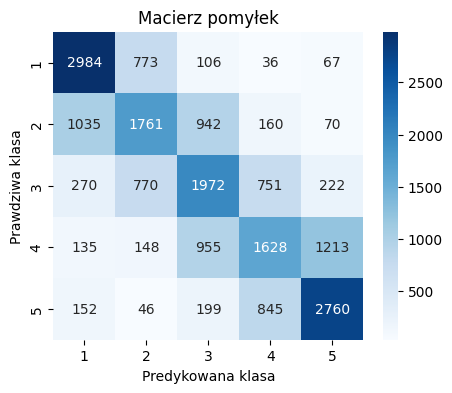

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(targets, preds)

# Create a heatmap
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.title('Macierz pomyłek')
plt.xlabel('Predykowana klasa')
plt.ylabel('Prawdziwa klasa')
plt.show()

# **Zadanie 1**

Napisz funkcję znajdującą i wyświetlającą  k  elementów zbioru testowego dla których model najbardziej się myli, czyli estymuje najmniejsze prawdopodobieństwa prawdziwej klasy. Softmax jest funkcją ściśle rosnącą, więc wystarczy znaleźć elementy z najmniejszą wartością nieznormalizowanego wyjścia z sieci (logita) dla prawdziwej klasy.


In [26]:
def find_most_misclassified(model, loaders, device, k=5):
    model.eval()

    misclassified_examples = []

    with torch.no_grad():
        for X_batch, target in loaders['test']:
            X_batch, target = X_batch.to(device), target.to(device)

            logits = model(X_batch)

            logits_for_true_class = logits.gather(1, target.view(-1, 1))

            for i in range(X_batch.size(0)):
                misclassified_examples.append((logits_for_true_class[i].item(), X_batch[i], target[i]))

    misclassified_examples.sort(key=lambda x: x[0])

    # Wyświetl k najgorszych przykładów
    for i in range(k):
        logit_value, _, true_class = misclassified_examples[i]
        print(f"Example {i+1}:")
        print(f"True Class: {true_class.item()}")
        print(f"Logit Value for True Class: {logit_value:.4f}")
        print("-" * 30)


In [27]:
find_most_misclassified(classifier, dataloaders, device, k=5)

Example 1:
True Class: 4
Logit Value for True Class: -2.5284
------------------------------
Example 2:
True Class: 4
Logit Value for True Class: -2.5111
------------------------------
Example 3:
True Class: 4
Logit Value for True Class: -2.3315
------------------------------
Example 4:
True Class: 4
Logit Value for True Class: -2.2644
------------------------------
Example 5:
True Class: 4
Logit Value for True Class: -2.1315
------------------------------


# **Zadanie 2**


Zbadaj wpływ wybranych parametrów funkcji ekstrakcji cech z tekstu TfidfVectorizer na skuteczność wytrenowanego modelu. Uruchom kilka eksperymentów z różnymi wartościami parametrów i porównaj dokładność wytrenowanego modelu na zbiorze walidacyjnym.


In [28]:
def train_tfidf(model, dataloaders, criterion, optimizer, lr_scheduler, num_epochs, device):
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0

        for inputs, labels in dataloaders['train']:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        lr_scheduler.step()

        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss / len(dataloaders['train']):.4f}")

        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0

        with torch.no_grad():
            for inputs, labels in dataloaders['val']:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

                _, predicted = torch.max(outputs, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()

        val_accuracy = val_correct / val_total
        print(f"Validation Loss: {val_loss / len(dataloaders['val']):.4f}, Validation Accuracy: {val_accuracy:.4f}")


In [29]:
from sklearn.metrics import accuracy_score

def run_experiment_with_params_from_list(train_dataset, val_dataset, test_dataset, params_list, device='cuda'):
    results = []

    for params in params_list:
        max_features = params["max_features"]
        ngram_range = params["ngram_range"]
        stop_words = params["stop_words"]
        lowercase = params["lowercase"]

        print(f"Testing: max_features={max_features}, ngram_range={ngram_range}, stop_words={stop_words}, lowercase={lowercase}")

        # Inicjalizacja TfidfVectorizer
        vectorizer = TfidfVectorizer(
            max_features=max_features,
            lowercase=lowercase,
            analyzer='word',
            ngram_range=ngram_range,
            stop_words=stop_words
        )

        # Ekstrakcja cech
        train_tfidf_matrix = vectorizer.fit_transform(train_dataset["text"])
        val_tfidf_matrix = vectorizer.transform(val_dataset["text"])
        test_tfidf_matrix = vectorizer.transform(test_dataset["text"])

        # Tworzenie datasetów
        train_data = make_dataset(train_tfidf_matrix, train_dataset["label"])
        val_data = make_dataset(val_tfidf_matrix, val_dataset["label"])
        test_data = make_dataset(test_tfidf_matrix, test_dataset["label"])

        batch_size = 256
        dataloaders = {
            'train': DataLoader(train_data, batch_size=batch_size, shuffle=True),
            'val': DataLoader(val_data, batch_size=batch_size, shuffle=False),
            'test': DataLoader(test_data, batch_size=batch_size, shuffle=False)
        }

        # Model
        model = SimpleNet(vocab_size=max_features, n_classes=5).to(device)
        criterion = torch.nn.CrossEntropyLoss()
        optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-5)
        lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=5, eta_min=1e-5)

        train_tfidf(model, dataloaders, criterion, optimizer, lr_scheduler, num_epochs=5, device=device)

        # Ocena na zbiorze walidacyjnym
        model.eval()
        val_tensor = torch.tensor(val_tfidf_matrix.todense(), dtype=torch.float32).to(device)
        val_preds = model(val_tensor).argmax(dim=1)
        val_acc = accuracy_score(val_dataset["label"], val_preds.cpu())

        print(f"Validation accuracy: {val_acc:.4f}")

        results.append({
            'params': params,
            'val_accuracy': val_acc
        })

    return results


In [30]:
params_list = [
    {"max_features": 1000, "ngram_range": (1, 1), "stop_words": "english", "lowercase": True},
    {"max_features": 1000, "ngram_range": (1, 2), "stop_words": "english", "lowercase": True},
    {"max_features": 5000, "ngram_range": (1, 1), "stop_words": "english", "lowercase": True},
    {"max_features": 3000, "ngram_range": (1, 1), "stop_words": None, "lowercase": True},
    {"max_features": 3000, "ngram_range": (1, 1), "stop_words": "english", "lowercase": False},
    {"max_features": 5000, "ngram_range": (1, 1), "stop_words": "english", "lowercase": True},
]

device = 'cuda' if torch.cuda.is_available() else 'cpu'
results = run_experiment_with_params_from_list(train_dataset, val_dataset, test_dataset, params_list, device)


Testing: max_features=1000, ngram_range=(1, 1), stop_words=english, lowercase=True
Epoch 1/5, Loss: 1.6014
Validation Loss: 1.5673, Validation Accuracy: 0.3621
Epoch 2/5, Loss: 1.5098
Validation Loss: 1.4351, Validation Accuracy: 0.3983
Epoch 3/5, Loss: 1.3901
Validation Loss: 1.3341, Validation Accuracy: 0.4405
Epoch 4/5, Loss: 1.3165
Validation Loss: 1.2835, Validation Accuracy: 0.4802
Epoch 5/5, Loss: 1.2827
Validation Loss: 1.2638, Validation Accuracy: 0.4906
Validation accuracy: 0.4906
Testing: max_features=1000, ngram_range=(1, 2), stop_words=english, lowercase=True
Epoch 1/5, Loss: 1.6135
Validation Loss: 1.5971, Validation Accuracy: 0.2058
Epoch 2/5, Loss: 1.5653
Validation Loss: 1.5166, Validation Accuracy: 0.4510
Epoch 3/5, Loss: 1.4629
Validation Loss: 1.4026, Validation Accuracy: 0.4810
Epoch 4/5, Loss: 1.3731
Validation Loss: 1.3373, Validation Accuracy: 0.4988
Epoch 5/5, Loss: 1.3292
Validation Loss: 1.3113, Validation Accuracy: 0.5045
Validation accuracy: 0.5045
Testing:

# **Zadanie 3**

Zbadaj wpływ wybranych hiperparametrów modelu (np. liczba warstw liniowych modelu, rozmiary warstw) i procesu uczenia (np. początkowa wartość stopy uczenia, liczba epok, typ i parametry planisty stopy uczenia, typ i parametry optymalizatora) na skuteczność wytrenowanego modelu. Uruchom kilka eksperymentów z różnymi wartościami hiperparametrów i porównaj dokładność wytrenowanego modelu na zbiorze walidacyjnym. Następnie wykonaj finalną ewaluację najlepszego modelu na zbiorze testowym.

In [31]:
import torch.optim as optim

# Hiperparametry do przetestowania
experiment_configs = [
    {"hidden_sizes": [64, 16], "learning_rate": 0.01, "optimizer": "Adam", "scheduler": None, "epochs": 10},
    {"hidden_sizes": [128, 32], "learning_rate": 0.001, "optimizer": "SGD", "scheduler": "StepLR", "epochs": 20},
    {"hidden_sizes": [256, 64, 16], "learning_rate": 0.005, "optimizer": "Adam", "scheduler": "CosineAnnealingLR", "epochs": 15},
    {"hidden_sizes": [512, 256, 64], "learning_rate": 0.001, "optimizer": "Adam", "scheduler": "CosineAnnealingLR", "epochs": 20},
    {"hidden_sizes": [256, 64], "learning_rate": 0.0005, "optimizer": "Adam", "scheduler": "CosineAnnealingLR", "epochs": 30}
]

In [32]:
class SimpleNetHyperparameters(nn.Module):
    def __init__(self, vocab_size: int, n_classes: int, hidden_sizes: list[int]):
        super().__init__()
        layers = []
        input_size = vocab_size

        # Tworzymy dynamicznie warstwy ukryte
        for size in hidden_sizes:
            layers.append(nn.Linear(input_size, size))
            layers.append(nn.ReLU())
            input_size = size

        self.feature_extractor = nn.Sequential(*layers)
        self.dropout = nn.Dropout(0.1)
        self.linear = nn.Linear(input_size, n_classes)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        features = self.feature_extractor(x)
        features = self.dropout(features)
        logits = self.linear(features)
        return logits


In [33]:
def train_and_evaluate(config, train_loader, val_loader):
    print(f"\nTrening z konfiguracją: {config}")

    model = SimpleNetHyperparameters(vocab_size, n_classes=5, hidden_sizes=config["hidden_sizes"]).to(device)
    criterion = nn.CrossEntropyLoss()

    # Wybór optymalizatora
    if config["optimizer"] == "Adam":
        optimizer = optim.Adam(model.parameters(), lr=config["learning_rate"])
    elif config["optimizer"] == "SGD":
        optimizer = optim.SGD(model.parameters(), lr=config["learning_rate"], momentum=0.9)

    # Wybór scheduler'a
    if config["scheduler"] == "StepLR":
        scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)
    elif config["scheduler"] == "CosineAnnealingLR":
        scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=config["epochs"])
    else:
        scheduler = None

    # Metryki
    metric_acc = torchmetrics.classification.Accuracy(task="multiclass", num_classes=5).to(device)

    for epoch in range(config["epochs"]):
        model.train()
        for X_batch, target in tqdm(train_loader, desc=f"Epoch {epoch+1}/{config['epochs']}"):
            X_batch, target = X_batch.to(device), target.to(device)
            optimizer.zero_grad()
            logits = model(X_batch)
            loss = criterion(logits, target)
            loss.backward()
            optimizer.step()

        # Aktualizacja scheduler'a
        if scheduler:
            scheduler.step()

        # Ewaluacja na zbiorze walidacyjnym
        model.eval()
        metric_acc.reset()
        with torch.no_grad():
            for X_batch, target in val_loader:
                X_batch, target = X_batch.to(device), target.to(device)
                logits = model(X_batch)
                preds = torch.argmax(logits, dim=1)
                metric_acc.update(preds, target)

        acc = metric_acc.compute().item()
        print(f"(Epoch {epoch+1}/{config['epochs']}) Accuracy: {acc:.4f}")

    return model, acc


In [34]:
best_model = None
best_accuracy = 0
results = []

train_loader = dataloaders['train']
val_loader = dataloaders['val']
test_loader = dataloaders['test']

for config in experiment_configs:

    model, acc = train_and_evaluate(config, train_loader, val_loader)
    results.append((config, acc))

    # Sprawdzamy, czy to najlepszy model
    if acc > best_accuracy:
        best_accuracy = acc
        best_model = model

# Wyświetlenie wyników
for config, acc in results:
    print(f"Konfiguracja: {config} | Dokładność: {acc:.4f}")



Trening z konfiguracją: {'hidden_sizes': [64, 16], 'learning_rate': 0.01, 'optimizer': 'Adam', 'scheduler': None, 'epochs': 10}


Epoch 1/10: 100%|██████████| 305/305 [00:02<00:00, 117.89it/s]


(Epoch 1/10) Accuracy: 0.5678


Epoch 2/10: 100%|██████████| 305/305 [00:02<00:00, 134.66it/s]


(Epoch 2/10) Accuracy: 0.5562


Epoch 3/10: 100%|██████████| 305/305 [00:02<00:00, 139.93it/s]


(Epoch 3/10) Accuracy: 0.5478


Epoch 4/10: 100%|██████████| 305/305 [00:02<00:00, 115.72it/s]


(Epoch 4/10) Accuracy: 0.5322


Epoch 5/10: 100%|██████████| 305/305 [00:02<00:00, 139.45it/s]


(Epoch 5/10) Accuracy: 0.5165


Epoch 6/10: 100%|██████████| 305/305 [00:02<00:00, 141.18it/s]


(Epoch 6/10) Accuracy: 0.5089


Epoch 7/10: 100%|██████████| 305/305 [00:02<00:00, 132.22it/s]


(Epoch 7/10) Accuracy: 0.5093


Epoch 8/10: 100%|██████████| 305/305 [00:02<00:00, 141.05it/s]


(Epoch 8/10) Accuracy: 0.5051


Epoch 9/10: 100%|██████████| 305/305 [00:02<00:00, 110.86it/s]


(Epoch 9/10) Accuracy: 0.5081


Epoch 10/10: 100%|██████████| 305/305 [00:02<00:00, 138.19it/s]


(Epoch 10/10) Accuracy: 0.5065

Trening z konfiguracją: {'hidden_sizes': [128, 32], 'learning_rate': 0.001, 'optimizer': 'SGD', 'scheduler': 'StepLR', 'epochs': 20}


Epoch 1/20: 100%|██████████| 305/305 [00:02<00:00, 129.89it/s]


(Epoch 1/20) Accuracy: 0.1888


Epoch 2/20: 100%|██████████| 305/305 [00:02<00:00, 135.83it/s]


(Epoch 2/20) Accuracy: 0.1888


Epoch 3/20: 100%|██████████| 305/305 [00:02<00:00, 125.57it/s]


(Epoch 3/20) Accuracy: 0.1888


Epoch 4/20: 100%|██████████| 305/305 [00:02<00:00, 108.27it/s]


(Epoch 4/20) Accuracy: 0.2063


Epoch 5/20: 100%|██████████| 305/305 [00:02<00:00, 135.24it/s]


(Epoch 5/20) Accuracy: 0.2063


Epoch 6/20: 100%|██████████| 305/305 [00:02<00:00, 133.55it/s]


(Epoch 6/20) Accuracy: 0.2063


Epoch 7/20: 100%|██████████| 305/305 [00:02<00:00, 133.81it/s]


(Epoch 7/20) Accuracy: 0.2063


Epoch 8/20: 100%|██████████| 305/305 [00:02<00:00, 117.44it/s]


(Epoch 8/20) Accuracy: 0.2063


Epoch 9/20: 100%|██████████| 305/305 [00:02<00:00, 126.21it/s]


(Epoch 9/20) Accuracy: 0.2063


Epoch 10/20: 100%|██████████| 305/305 [00:02<00:00, 133.22it/s]


(Epoch 10/20) Accuracy: 0.2063


Epoch 11/20: 100%|██████████| 305/305 [00:02<00:00, 121.06it/s]


(Epoch 11/20) Accuracy: 0.2063


Epoch 12/20: 100%|██████████| 305/305 [00:02<00:00, 134.11it/s]


(Epoch 12/20) Accuracy: 0.2063


Epoch 13/20: 100%|██████████| 305/305 [00:02<00:00, 112.49it/s]


(Epoch 13/20) Accuracy: 0.2063


Epoch 14/20: 100%|██████████| 305/305 [00:02<00:00, 133.46it/s]


(Epoch 14/20) Accuracy: 0.2063


Epoch 15/20: 100%|██████████| 305/305 [00:02<00:00, 135.30it/s]


(Epoch 15/20) Accuracy: 0.2063


Epoch 16/20: 100%|██████████| 305/305 [00:02<00:00, 135.78it/s]


(Epoch 16/20) Accuracy: 0.2063


Epoch 17/20: 100%|██████████| 305/305 [00:02<00:00, 112.11it/s]


(Epoch 17/20) Accuracy: 0.2063


Epoch 18/20: 100%|██████████| 305/305 [00:02<00:00, 118.56it/s]


(Epoch 18/20) Accuracy: 0.2063


Epoch 19/20: 100%|██████████| 305/305 [00:02<00:00, 135.09it/s]


(Epoch 19/20) Accuracy: 0.2063


Epoch 20/20: 100%|██████████| 305/305 [00:02<00:00, 133.04it/s]


(Epoch 20/20) Accuracy: 0.2063

Trening z konfiguracją: {'hidden_sizes': [256, 64, 16], 'learning_rate': 0.005, 'optimizer': 'Adam', 'scheduler': 'CosineAnnealingLR', 'epochs': 15}


Epoch 1/15: 100%|██████████| 305/305 [00:02<00:00, 126.92it/s]


(Epoch 1/15) Accuracy: 0.5644


Epoch 2/15: 100%|██████████| 305/305 [00:02<00:00, 112.48it/s]


(Epoch 2/15) Accuracy: 0.5587


Epoch 3/15: 100%|██████████| 305/305 [00:02<00:00, 123.45it/s]


(Epoch 3/15) Accuracy: 0.5487


Epoch 4/15: 100%|██████████| 305/305 [00:02<00:00, 113.28it/s]


(Epoch 4/15) Accuracy: 0.5325


Epoch 5/15: 100%|██████████| 305/305 [00:02<00:00, 128.15it/s]


(Epoch 5/15) Accuracy: 0.5289


Epoch 6/15: 100%|██████████| 305/305 [00:02<00:00, 117.63it/s]


(Epoch 6/15) Accuracy: 0.5202


Epoch 7/15: 100%|██████████| 305/305 [00:02<00:00, 112.51it/s]


(Epoch 7/15) Accuracy: 0.5275


Epoch 8/15: 100%|██████████| 305/305 [00:02<00:00, 127.88it/s]


(Epoch 8/15) Accuracy: 0.5251


Epoch 9/15: 100%|██████████| 305/305 [00:02<00:00, 127.72it/s]


(Epoch 9/15) Accuracy: 0.5247


Epoch 10/15: 100%|██████████| 305/305 [00:02<00:00, 117.03it/s]


(Epoch 10/15) Accuracy: 0.5275


Epoch 11/15: 100%|██████████| 305/305 [00:02<00:00, 103.30it/s]


(Epoch 11/15) Accuracy: 0.5239


Epoch 12/15: 100%|██████████| 305/305 [00:02<00:00, 128.15it/s]


(Epoch 12/15) Accuracy: 0.5301


Epoch 13/15: 100%|██████████| 305/305 [00:02<00:00, 127.85it/s]


(Epoch 13/15) Accuracy: 0.5289


Epoch 14/15: 100%|██████████| 305/305 [00:02<00:00, 128.80it/s]


(Epoch 14/15) Accuracy: 0.5282


Epoch 15/15: 100%|██████████| 305/305 [00:02<00:00, 119.36it/s]


(Epoch 15/15) Accuracy: 0.5297

Trening z konfiguracją: {'hidden_sizes': [512, 256, 64], 'learning_rate': 0.001, 'optimizer': 'Adam', 'scheduler': 'CosineAnnealingLR', 'epochs': 20}


Epoch 1/20: 100%|██████████| 305/305 [00:02<00:00, 115.41it/s]


(Epoch 1/20) Accuracy: 0.5636


Epoch 2/20: 100%|██████████| 305/305 [00:02<00:00, 116.13it/s]


(Epoch 2/20) Accuracy: 0.5634


Epoch 3/20: 100%|██████████| 305/305 [00:02<00:00, 130.36it/s]


(Epoch 3/20) Accuracy: 0.5553


Epoch 4/20: 100%|██████████| 305/305 [00:02<00:00, 125.50it/s]


(Epoch 4/20) Accuracy: 0.5392


Epoch 5/20: 100%|██████████| 305/305 [00:02<00:00, 103.01it/s]


(Epoch 5/20) Accuracy: 0.5208


Epoch 6/20: 100%|██████████| 305/305 [00:02<00:00, 129.74it/s]


(Epoch 6/20) Accuracy: 0.5149


Epoch 7/20: 100%|██████████| 305/305 [00:02<00:00, 126.74it/s]


(Epoch 7/20) Accuracy: 0.5092


Epoch 8/20: 100%|██████████| 305/305 [00:02<00:00, 116.43it/s]


(Epoch 8/20) Accuracy: 0.5128


Epoch 9/20: 100%|██████████| 305/305 [00:02<00:00, 114.64it/s]


(Epoch 9/20) Accuracy: 0.5124


Epoch 10/20: 100%|██████████| 305/305 [00:02<00:00, 116.03it/s]


(Epoch 10/20) Accuracy: 0.5138


Epoch 11/20: 100%|██████████| 305/305 [00:02<00:00, 127.80it/s]


(Epoch 11/20) Accuracy: 0.5138


Epoch 12/20: 100%|██████████| 305/305 [00:02<00:00, 127.80it/s]


(Epoch 12/20) Accuracy: 0.5127


Epoch 13/20: 100%|██████████| 305/305 [00:02<00:00, 126.05it/s]


(Epoch 13/20) Accuracy: 0.5109


Epoch 14/20: 100%|██████████| 305/305 [00:02<00:00, 106.02it/s]


(Epoch 14/20) Accuracy: 0.5141


Epoch 15/20: 100%|██████████| 305/305 [00:02<00:00, 115.45it/s]


(Epoch 15/20) Accuracy: 0.5125


Epoch 16/20: 100%|██████████| 305/305 [00:02<00:00, 128.55it/s]


(Epoch 16/20) Accuracy: 0.5141


Epoch 17/20: 100%|██████████| 305/305 [00:02<00:00, 128.48it/s]


(Epoch 17/20) Accuracy: 0.5128


Epoch 18/20: 100%|██████████| 305/305 [00:02<00:00, 114.75it/s]


(Epoch 18/20) Accuracy: 0.5125


Epoch 19/20: 100%|██████████| 305/305 [00:02<00:00, 116.62it/s]


(Epoch 19/20) Accuracy: 0.5123


Epoch 20/20: 100%|██████████| 305/305 [00:02<00:00, 128.62it/s]


(Epoch 20/20) Accuracy: 0.5133

Trening z konfiguracją: {'hidden_sizes': [256, 64], 'learning_rate': 0.0005, 'optimizer': 'Adam', 'scheduler': 'CosineAnnealingLR', 'epochs': 30}


Epoch 1/30: 100%|██████████| 305/305 [00:02<00:00, 117.28it/s]


(Epoch 1/30) Accuracy: 0.5712


Epoch 2/30: 100%|██████████| 305/305 [00:02<00:00, 129.96it/s]


(Epoch 2/30) Accuracy: 0.5668


Epoch 3/30: 100%|██████████| 305/305 [00:02<00:00, 110.88it/s]


(Epoch 3/30) Accuracy: 0.5654


Epoch 4/30: 100%|██████████| 305/305 [00:02<00:00, 129.58it/s]


(Epoch 4/30) Accuracy: 0.5602


Epoch 5/30: 100%|██████████| 305/305 [00:02<00:00, 128.59it/s]


(Epoch 5/30) Accuracy: 0.5572


Epoch 6/30: 100%|██████████| 305/305 [00:02<00:00, 131.24it/s]


(Epoch 6/30) Accuracy: 0.5497


Epoch 7/30: 100%|██████████| 305/305 [00:02<00:00, 118.09it/s]


(Epoch 7/30) Accuracy: 0.5458


Epoch 8/30: 100%|██████████| 305/305 [00:02<00:00, 105.58it/s]


(Epoch 8/30) Accuracy: 0.5401


Epoch 9/30: 100%|██████████| 305/305 [00:02<00:00, 132.00it/s]


(Epoch 9/30) Accuracy: 0.5355


Epoch 10/30: 100%|██████████| 305/305 [00:02<00:00, 131.82it/s]


(Epoch 10/30) Accuracy: 0.5319


Epoch 11/30: 100%|██████████| 305/305 [00:02<00:00, 127.84it/s]


(Epoch 11/30) Accuracy: 0.5277


Epoch 12/30: 100%|██████████| 305/305 [00:02<00:00, 109.85it/s]


(Epoch 12/30) Accuracy: 0.5242


Epoch 13/30: 100%|██████████| 305/305 [00:02<00:00, 128.06it/s]


(Epoch 13/30) Accuracy: 0.5217


Epoch 14/30: 100%|██████████| 305/305 [00:02<00:00, 133.19it/s]


(Epoch 14/30) Accuracy: 0.5167


Epoch 15/30: 100%|██████████| 305/305 [00:02<00:00, 129.82it/s]


(Epoch 15/30) Accuracy: 0.5147


Epoch 16/30: 100%|██████████| 305/305 [00:02<00:00, 117.19it/s]


(Epoch 16/30) Accuracy: 0.5107


Epoch 17/30: 100%|██████████| 305/305 [00:02<00:00, 118.62it/s]


(Epoch 17/30) Accuracy: 0.5095


Epoch 18/30: 100%|██████████| 305/305 [00:02<00:00, 130.69it/s]


(Epoch 18/30) Accuracy: 0.5045


Epoch 19/30: 100%|██████████| 305/305 [00:02<00:00, 130.41it/s]


(Epoch 19/30) Accuracy: 0.5055


Epoch 20/30: 100%|██████████| 305/305 [00:02<00:00, 129.77it/s]


(Epoch 20/30) Accuracy: 0.5040


Epoch 21/30: 100%|██████████| 305/305 [00:03<00:00, 99.01it/s] 


(Epoch 21/30) Accuracy: 0.5018


Epoch 22/30: 100%|██████████| 305/305 [00:02<00:00, 131.91it/s]


(Epoch 22/30) Accuracy: 0.5004


Epoch 23/30: 100%|██████████| 305/305 [00:02<00:00, 129.12it/s]


(Epoch 23/30) Accuracy: 0.4988


Epoch 24/30: 100%|██████████| 305/305 [00:02<00:00, 131.01it/s]


(Epoch 24/30) Accuracy: 0.4998


Epoch 25/30: 100%|██████████| 305/305 [00:02<00:00, 119.76it/s]


(Epoch 25/30) Accuracy: 0.4995


Epoch 26/30: 100%|██████████| 305/305 [00:02<00:00, 117.33it/s]


(Epoch 26/30) Accuracy: 0.4995


Epoch 27/30: 100%|██████████| 305/305 [00:02<00:00, 132.94it/s]


(Epoch 27/30) Accuracy: 0.4992


Epoch 28/30: 100%|██████████| 305/305 [00:02<00:00, 130.16it/s]


(Epoch 28/30) Accuracy: 0.4992


Epoch 29/30: 100%|██████████| 305/305 [00:02<00:00, 128.53it/s]


(Epoch 29/30) Accuracy: 0.4995


Epoch 30/30: 100%|██████████| 305/305 [00:02<00:00, 105.91it/s]


(Epoch 30/30) Accuracy: 0.4993
Konfiguracja: {'hidden_sizes': [64, 16], 'learning_rate': 0.01, 'optimizer': 'Adam', 'scheduler': None, 'epochs': 10} | Dokładność: 0.5065
Konfiguracja: {'hidden_sizes': [128, 32], 'learning_rate': 0.001, 'optimizer': 'SGD', 'scheduler': 'StepLR', 'epochs': 20} | Dokładność: 0.2063
Konfiguracja: {'hidden_sizes': [256, 64, 16], 'learning_rate': 0.005, 'optimizer': 'Adam', 'scheduler': 'CosineAnnealingLR', 'epochs': 15} | Dokładność: 0.5297
Konfiguracja: {'hidden_sizes': [512, 256, 64], 'learning_rate': 0.001, 'optimizer': 'Adam', 'scheduler': 'CosineAnnealingLR', 'epochs': 20} | Dokładność: 0.5133
Konfiguracja: {'hidden_sizes': [256, 64], 'learning_rate': 0.0005, 'optimizer': 'Adam', 'scheduler': 'CosineAnnealingLR', 'epochs': 30} | Dokładność: 0.4993


In [35]:
def evaluate_on_test(model, test_loader):
    model.eval()
    metric_acc = torchmetrics.classification.Accuracy(task="multiclass", num_classes=5).to(device)

    with torch.no_grad():
        for X_batch, target in test_loader:
            X_batch, target = X_batch.to(device), target.to(device)
            logits = model(X_batch)
            preds = torch.argmax(logits, dim=1)
            metric_acc.update(preds, target)

    test_acc = metric_acc.compute().item()
    print(f"Dokładność na zbiorze testowym: {test_acc:.4f}")
    return test_acc

test_accuracy = evaluate_on_test(best_model, test_loader)


Dokładność na zbiorze testowym: 0.5253
